In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix  
import os
from torch import nn


In [ ]:
def IoU_coeff(y_true, y_pred):
    axes = (0,1) 
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) 
    mask = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask - intersection
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    return iou

### Not used

In [ ]:
# def compute_iou(y_true, y_pred):
#     # ytrue, ypred is a flatten vector
#     y_pred = y_pred.flatten()
#     y_true = y_true.flatten()
#     current = confusion_matrix(y_true, y_pred, labels=[0, 1])
#     # compute mean iou
#     intersection = np.diag(current)
#     ground_truth_set = current.sum(axis=1)
#     predicted_set = current.sum(axis=0)
#     union = ground_truth_set + predicted_set - intersection
#     IoU = intersection / union.astype(np.float32)
#     return np.mean(IoU)

In [ ]:
def load_and_get_iou(img_name ,model, feature_extractor, show_img = False, img_dir = "/home/muhammad.huzaifa/Test_scripts/Deeplabv3+/amine-work/people_segmentation/Gauss_noise/5.0", mask_dir = "/home/muhammad.huzaifa/Test_scripts/Deeplabv3+/amine-work/people_segmentation/masks", pred_mask_dir = "/home/muhammad.huzaifa/Test_scripts/Deeplabv3+/amine-work/people_segmentation/Gauss_noise/pred_1.0", threshold = 0.02, save_mask=True):
    image = Image.open(f'{img_dir}/{img_name}.jpg')
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    upsampled_logits = nn.functional.interpolate(logits,
                    size=image.size[::-1], # (height, width)
                    mode='bilinear',
                    align_corners=False)
    pred_mask = upsampled_logits.argmax(dim=1)[0] == 12
    pred_mask = pred_mask.cpu().detach().numpy().astype(int)
    original_mask = np.asarray(Image.open(f'{mask_dir}/{img_name}.png'))
    if show_img==True:
        plt.subplot(1,3,1)
        plt.imshow(original_mask, cmap="gray")
        plt.subplot(1,3,2)
        plt.imshow(pred_mask, cmap = "gray")
        plt.subplot(1,3,3)
        plt.imshow(image)
    if save_mask:
        # save predicted mask
        plt.imsave(f"{pred_mask_dir}/{img_name}.png", pred_mask, cmap='gray')

    return IoU_coeff(original_mask, pred_mask)

3.2437727567080484e-09

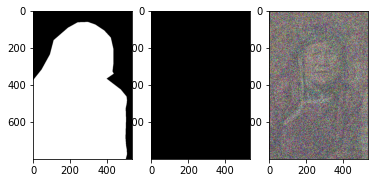

In [ ]:
load_and_get_iou("woman-tibet-indigenous-39029", model = model_b0,feature_extractor=feature_extractor_b0, show_img = True)

# load_and_get_iou("young-girl-ballerina-dance-591679", model = model_b0,feature_extractor=feature_extractor_b0, show_img = True)

In [ ]:
all_iou_b0 = []

for root, dirs, files in os.walk("./people_segmentation/images/", topdown=False):
    for img_name in files:
        all_iou_b0.append(load_and_get_iou(img_name[:-4]))


## Segformer B5 Model

In [ ]:
feature_extractor_b5 = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
model_b5 = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")

3.2437727567080484e-09

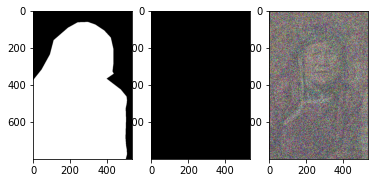

In [ ]:
# load_and_get_iou("young-girl-ballerina-dance-591679", model = model_b5,feature_extractor=feature_extractor_b5, show_img = True)

load_and_get_iou("woman-tibet-indigenous-39029", model = model_b5,feature_extractor=feature_extractor_b5, show_img = True)

# load_and_get_iou("young-girl-ballerina-dance-591679", model = model_b0,feature_extractor=feature_extractor_b0, show_img = True)

## Apply to whole dataset

In [ ]:
import os
import pandas as pd

iou_original = {}
for dir_name in ["0.1","0.01","0.001", "0.3"]:
    iou = {}
    # for ratio in [0.3, 0.5, 0.7]:
    for root, dirs, files in os.walk("/home/muhammad.huzaifa/Test_scripts/Deeplabv3+/amine-work/people_segmentation/images", topdown=False):
        for img_name in files:
            img_path = f'/home/muhammad.huzaifa/Test_scripts/Deeplabv3+/amine-work/people_segmentation/Salt_n_pepper/{dir_name}'
            pred_mask_path = f'/home/muhammad.huzaifa/Test_scripts/Deeplabv3+/amine-work/people_segmentation/Salt_n_pepper/pred_{dir_name}'
#             iou_original.append()
            iou[img_name[:-4]] = load_and_get_iou(img_name[:-4], model = model_b5,feature_extractor=feature_extractor_b5, save_mask=True, img_dir = img_path, pred_mask_dir = pred_mask_path)
#             break
        iou_df = pd.DataFrame.from_dict({"name": iou.keys(), "iou": iou.values()})
        iou_df.to_csv(f"/home/muhammad.huzaifa/Test_scripts/Deeplabv3+/amine-work/people_segmentation/Salt_n_pepper/pred_{dir_name}/iou.csv")
            
            # drop_patches(img_name[:-4], noise_ratio=ratio)
            # drop_random(img_name[:-4], noise_ratio=ratio)
            # break

In [ ]:
iou

{'pexels-photo-68721': 1.8950807457994005e-09}

In [ ]:

import pandas as pd

In [ ]:
df1 = pd.read_csv(r"/home/muhammad.huzaifa/Test_scripts/Deeplabv3+/amine-work/people_segmentation/Gauss_noise/pred_5.0/iou.csv")

In [ ]:
df1.head()

,Unnamed: 0,name,iou
0,0,pexels-photo-68721,1.895081e-09
1,1,pexels-photo-698555,1.241542e-08
2,2,pexels-photo-346831,1.414207e-08
3,3,football-american-football-player-sport-163530,2.745591e-01
4,4,pexels-photo-261385_P12XypOYkI,3.440671e-09


In [ ]:
df1[['iou']].mean(axis=0)

iou    0.013818
dtype: float64